In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from os import path, makedirs

In [2]:
corpus_csv_file = "corpus_scores.csv"
corpus_df = pd.read_csv(corpus_csv_file)

Styles: ['minimal', 'fluency']
Teams: ['UAM-CSI', 'Viking-7B', 'Viking-13B']
Gleu


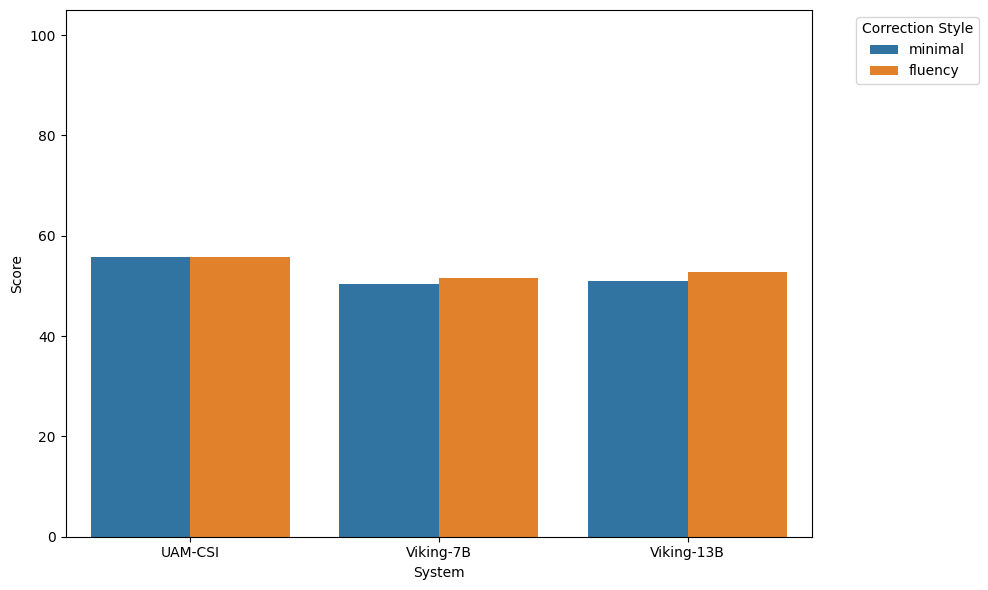

Precision


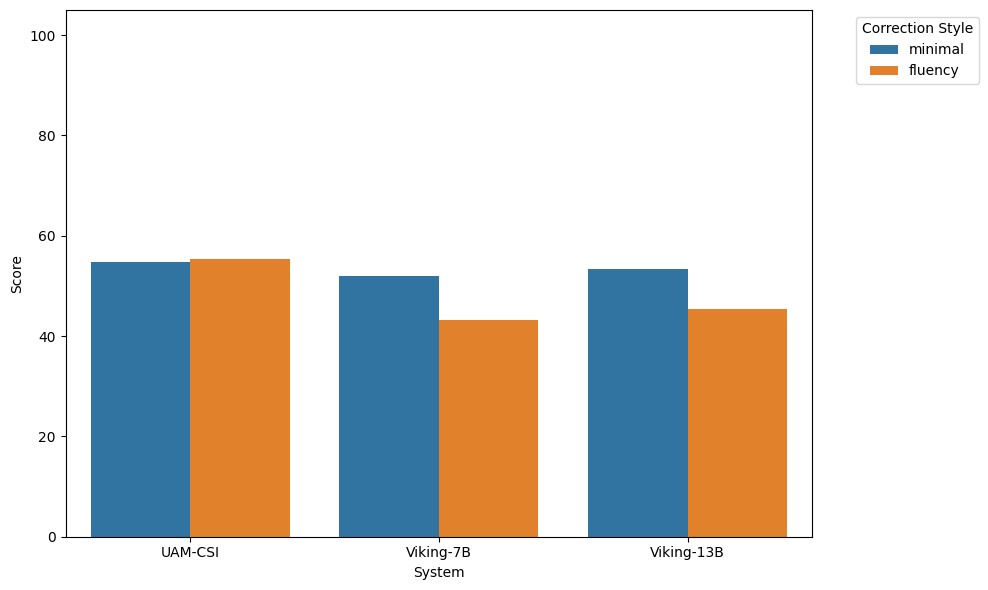

Recall


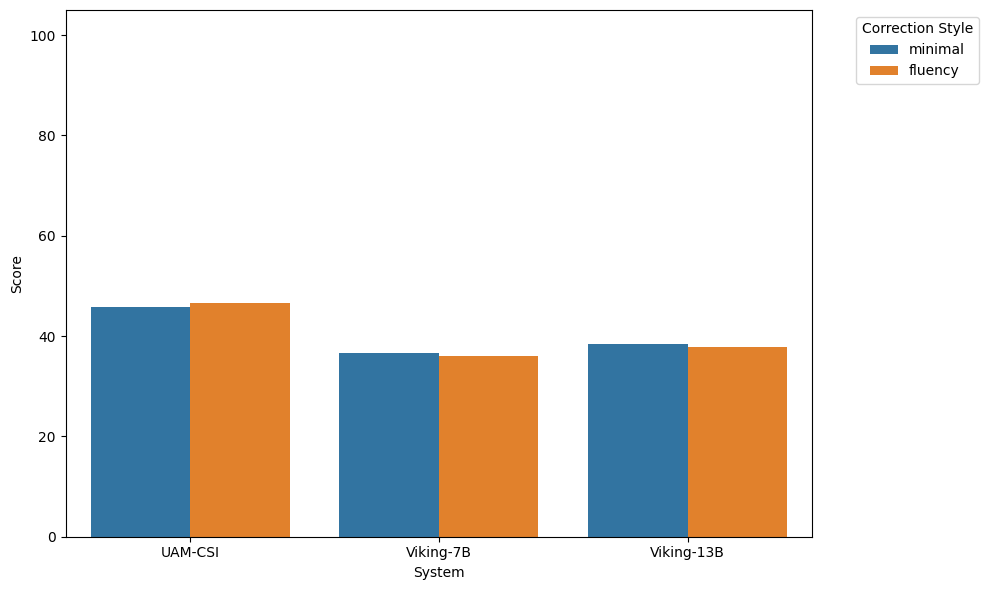

F0.5


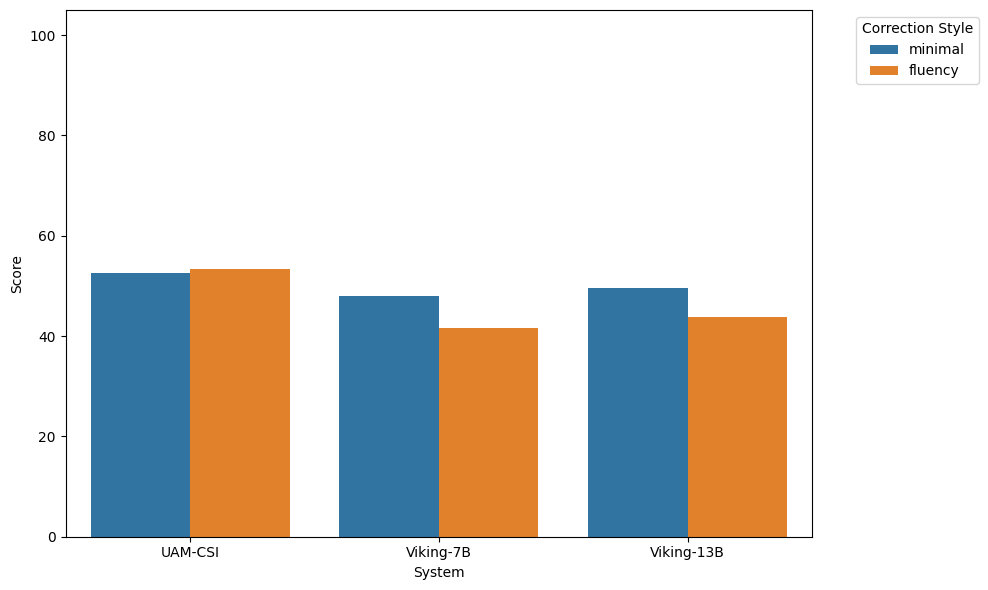

Scribendi Score


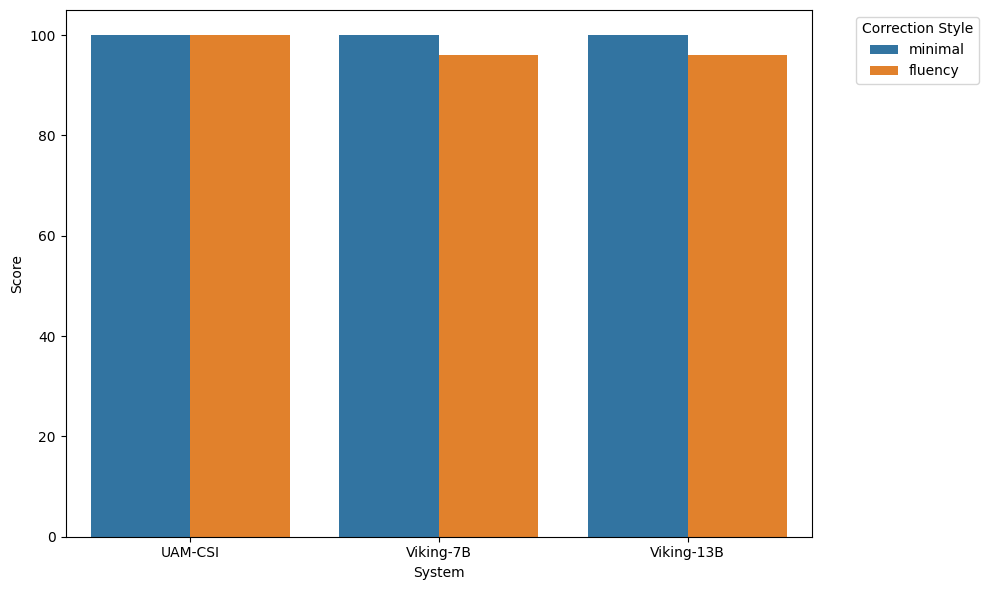

In [3]:
styles_label = "correction_style"
styles = corpus_df[styles_label].unique().tolist()
print(f"Styles: {styles}")


team_label = "system"
teams = corpus_df[team_label].unique().tolist()
print(f"Teams: {teams}")


corpus_df_long = corpus_df.melt(
    id_vars=[styles_label, team_label],
    var_name="score_type",
    value_name="score"
)


def process_label(label):
    return label.replace("_", " ").title()


corpus_df_long["score_type"] = corpus_df_long["score_type"].apply(
    process_label)


plots_dir = "plots/"
makedirs(plots_dir, exist_ok=True)


def normalize_label(label: str):
    return label.lower().replace(".", "").replace(" ", "_")


scores = corpus_df_long["score_type"].unique()
for score in scores:
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=corpus_df_long[corpus_df_long["score_type"] == score],
        x="system",
        y="score",
        hue="correction_style"
    )
    plt.xlabel("System")
    plt.ylabel("Score")
    plt.ylim(0, 105)
    plt.legend(
        title='Correction Style',
        bbox_to_anchor=(1.05, 1),
        loc='upper left'
    )
    plt.tight_layout()
    file_name = f"{normalize_label(score)}.png"
    file_path = path.join(plots_dir, file_name)
    plt.savefig(file_path)
    print(score)
    plt.show()

/tmp/ipykernel_18174/2823624251.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pairwise_df = pairwise_df.replace(essay_id_subs)


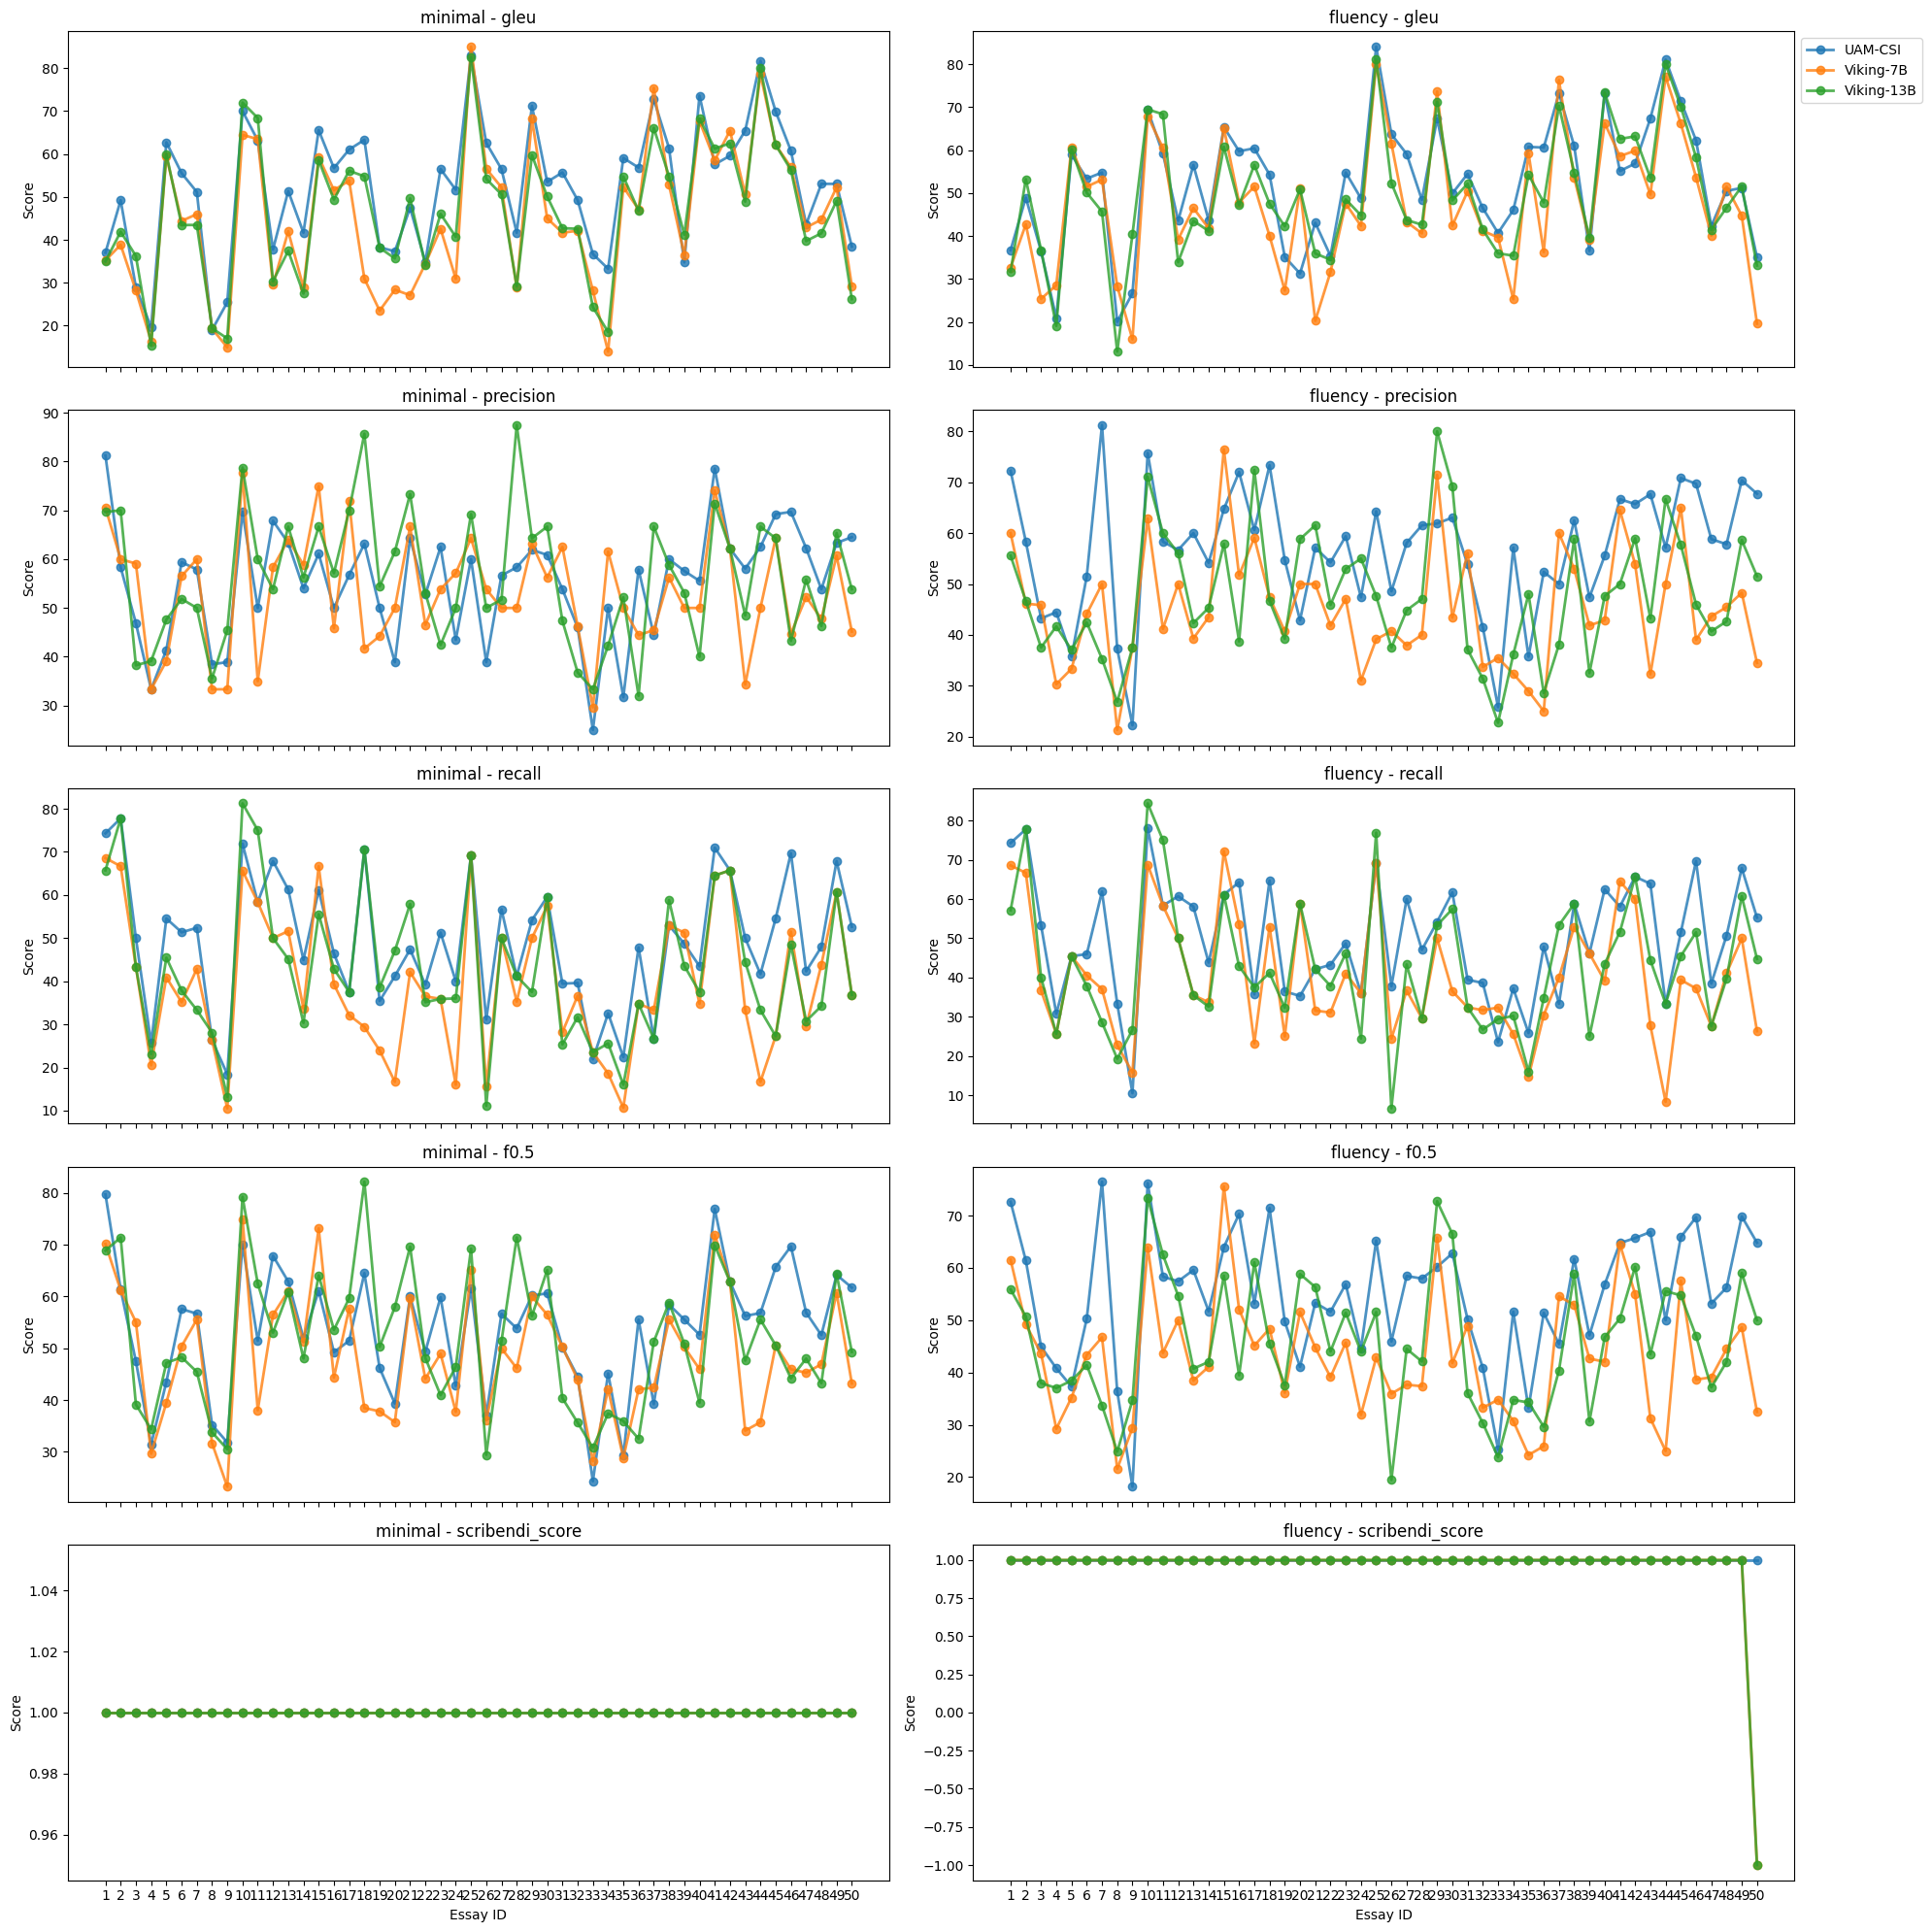

In [4]:
pairwise_csv = "scores.csv"
pairwise_df = pd.read_csv(pairwise_csv)

essay_ids = pairwise_df["essay_id"].unique().tolist()

essay_id_subs = {
    essay_id: i for i, essay_id in enumerate(essay_ids, 1)
}

pairwise_df = pairwise_df.replace(essay_id_subs)

# Define score columns and prepare color map
score_cols = ['gleu', 'precision', 'recall', 'f0.5', 'scribendi_score']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
score_color_map = dict(zip(score_cols, colors))

# Score columns

# Ensure essay_id is a string for cleaner plotting
pairwise_df['essay_id'] = pairwise_df['essay_id'].astype(str)

# Prepare all (correction_style, score_type) pairs
styles = pairwise_df['correction_style'].unique()
n_cols = len(styles)
n_rows = len(score_cols)

fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(10 * n_cols, 4 * n_rows),
    sharex=True
)

# If 1D axes, expand to 2D for consistent indexing
if n_rows == 1:
    axes = [axes]
if n_cols == 1:
    axes = [[ax] for ax in axes]

# Iterate over correction styles and scores
for i, style in enumerate(styles):
    for j, score in enumerate(score_cols):
        ax = axes[j][i]
        subset = pairwise_df[pairwise_df['correction_style'] == style]

        # Plot each system's line
        for system in subset['system'].unique():
            sys_data = subset[subset['system'] == system]
            ax.plot(
                sys_data['essay_id'], sys_data[score],
                label=system, marker='o', linewidth=2, alpha=0.8
            )

        ax.set_title(f'{style} - {score}')
        ax.set_ylabel('Score')
        if j == n_rows - 1:
            ax.set_xlabel('Essay ID')
        if j == 0 and i == n_cols - 1:
            # Legend on the right
            ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

/tmp/ipykernel_18174/1639872874.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pairwise_df = pairwise_df.replace(essay_id_subs)


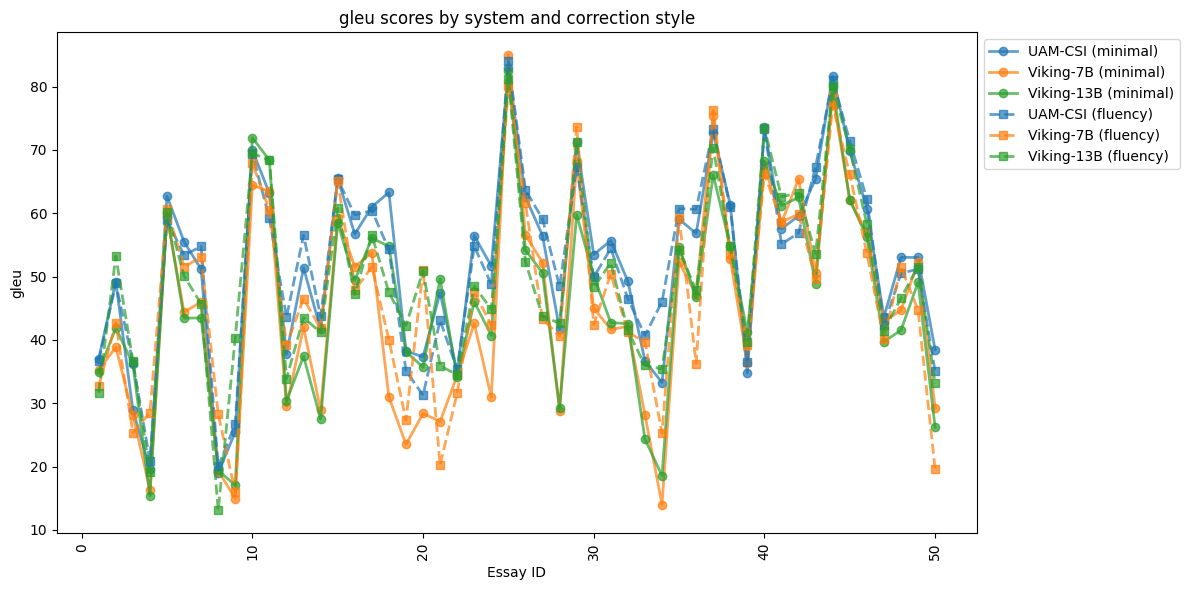

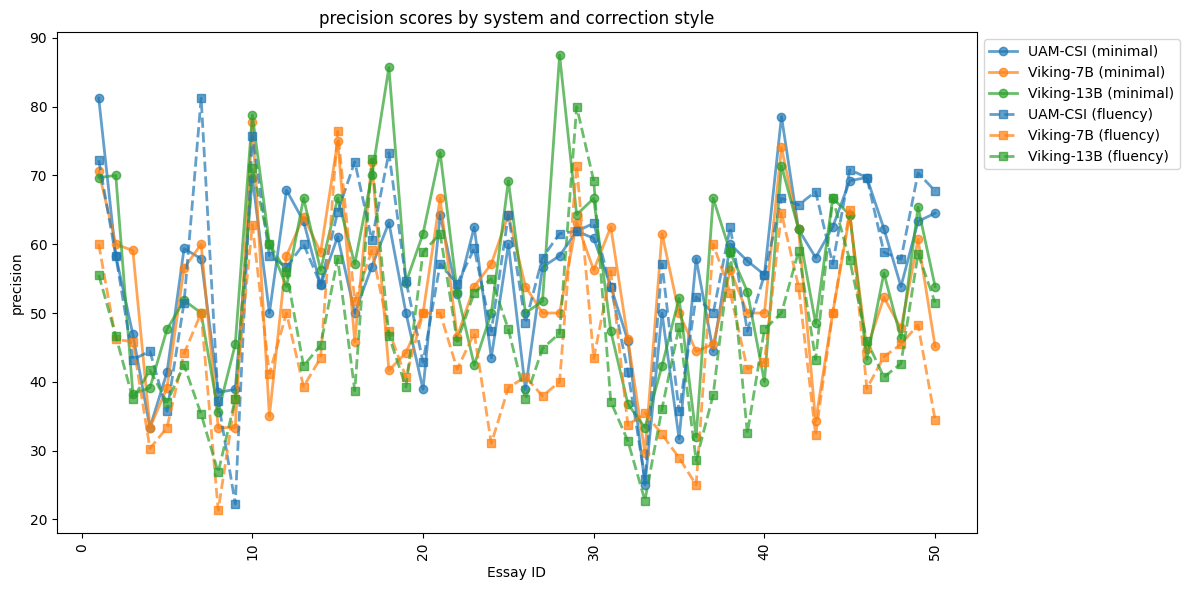

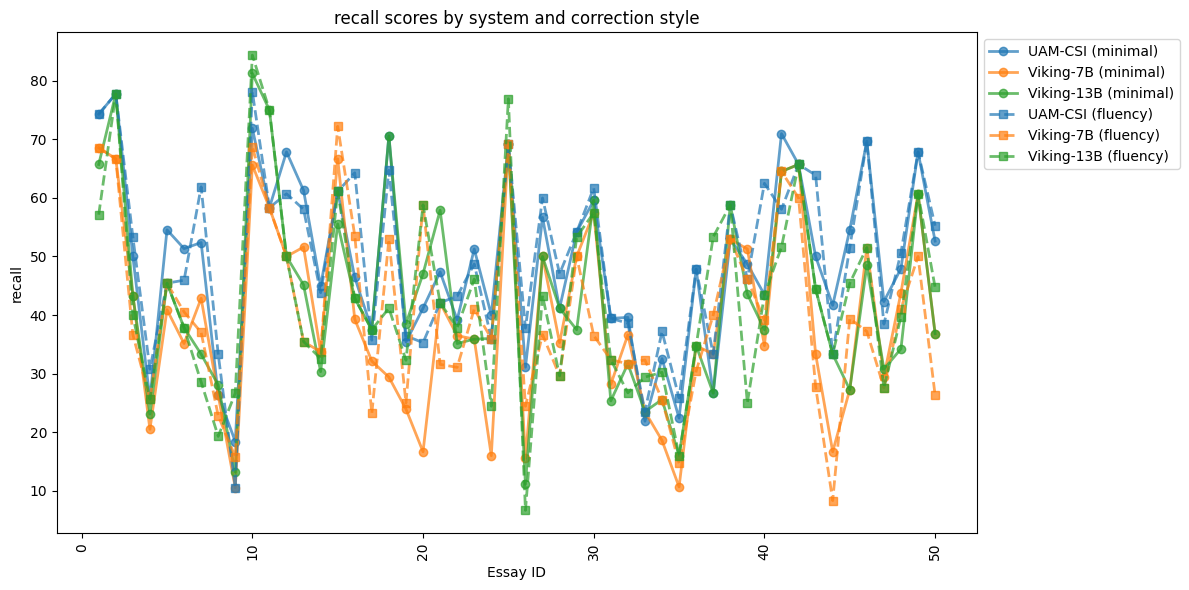

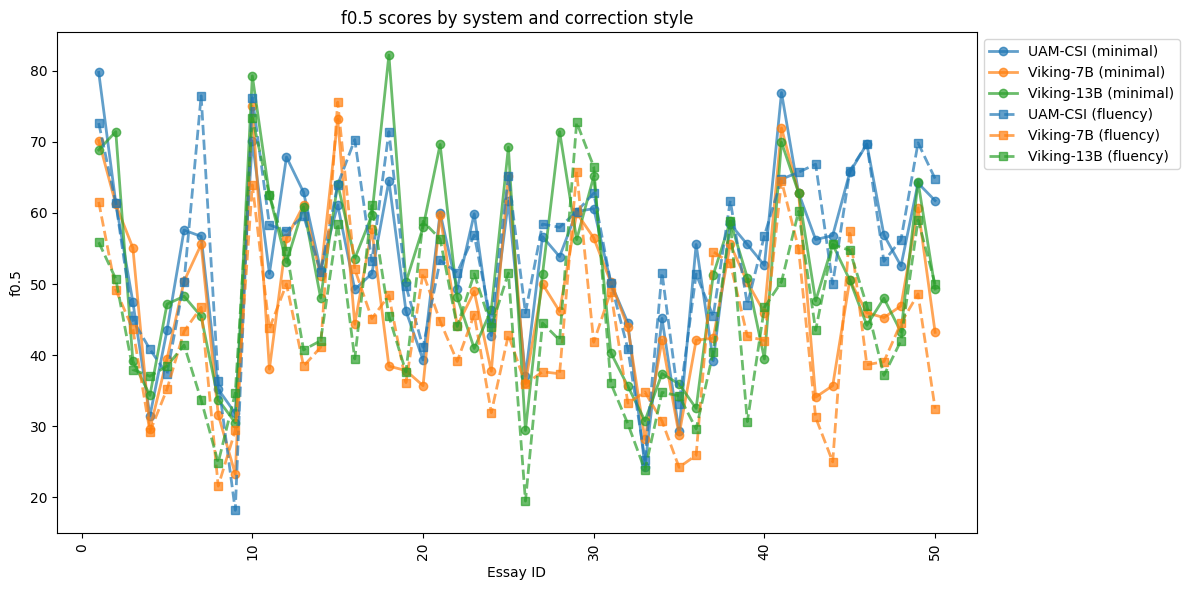

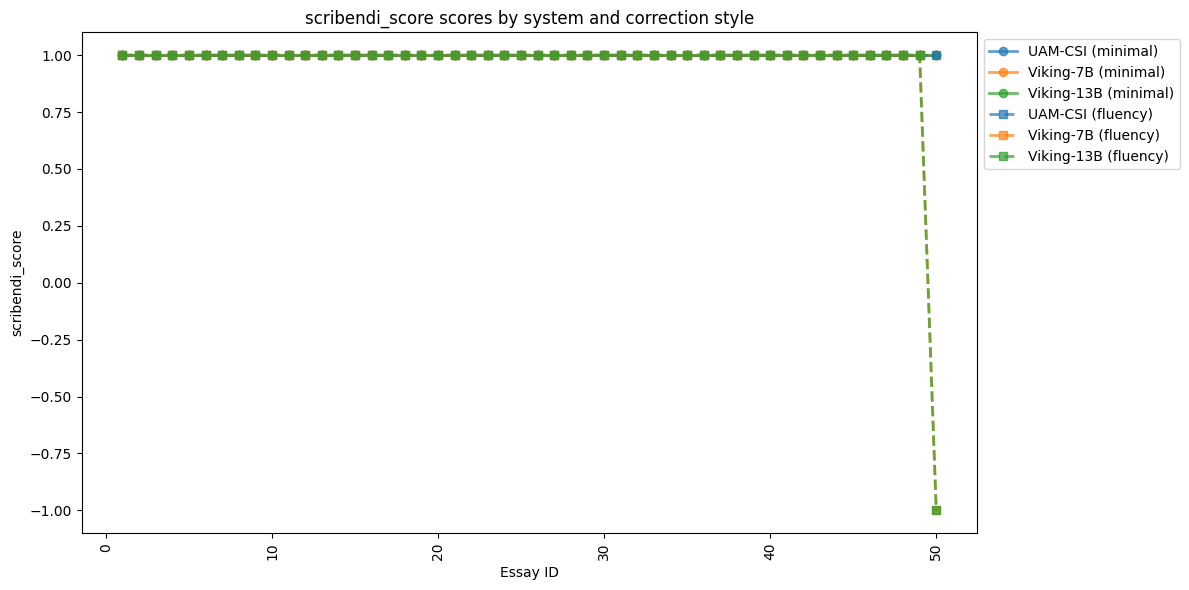

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
pairwise_csv = "scores.csv"
pairwise_df = pd.read_csv(pairwise_csv)

# Normalize essay_id to be numeric and consistent
essay_ids = pairwise_df["essay_id"].unique().tolist()
essay_id_subs = {essay_id: i for i, essay_id in enumerate(essay_ids, 1)}
pairwise_df = pairwise_df.replace(essay_id_subs)
# pairwise_df['essay_id'] = pairwise_df['essay_id'].astype(str)
pairwise_df['essay_id'] = pairwise_df['essay_id']

# Define score columns
score_cols = ['gleu', 'precision', 'recall', 'f0.5', 'scribendi_score']

# Determine all systems and assign them distinct colors
comparison_systems = pairwise_df['system'].unique()
color_palette = plt.get_cmap('tab10')
system_color_map = {
    system: color_palette(i % 10) for i, system in enumerate(comparison_systems)
}

# Define line styles and markers by correction_style
styles = pairwise_df['correction_style'].unique()
linestyles = {
    styles[0]: 'solid',
    styles[1]: 'dashed',
}
markers = {
    styles[0]: 'o',  # Circle
    styles[1]: 's',  # Square
}

# Create one plot per score type
for score in score_cols:
    fig, ax = plt.subplots(figsize=(12, 6))

    for style in styles:
        style_subset = pairwise_df[pairwise_df['correction_style'] == style]

        for system in comparison_systems:
            sys_data = style_subset[
                style_subset['system'] == system
            ].sort_values(by='essay_id')
            if sys_data.empty:
                continue  # Skip if this combination doesn't exist
            label = f"{system} ({style})"
            ax.plot(
                sys_data['essay_id'], sys_data[score],
                label=label,
                color=system_color_map[system],
                linestyle=linestyles[style],
                marker=markers[style],
                linewidth=2,
                alpha=0.7
            )

    ax.set_title(f"{score} scores by system and correction style")
    ax.set_xlabel("Essay ID")
    ax.set_ylabel(score)
    # ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.xticks(rotation=90)
    plt.tight_layout()
    file_name = f"all-{score}.png"
    file_path = path.join(plots_dir, file_name)
    plt.savefig(file_path)
    plt.show()

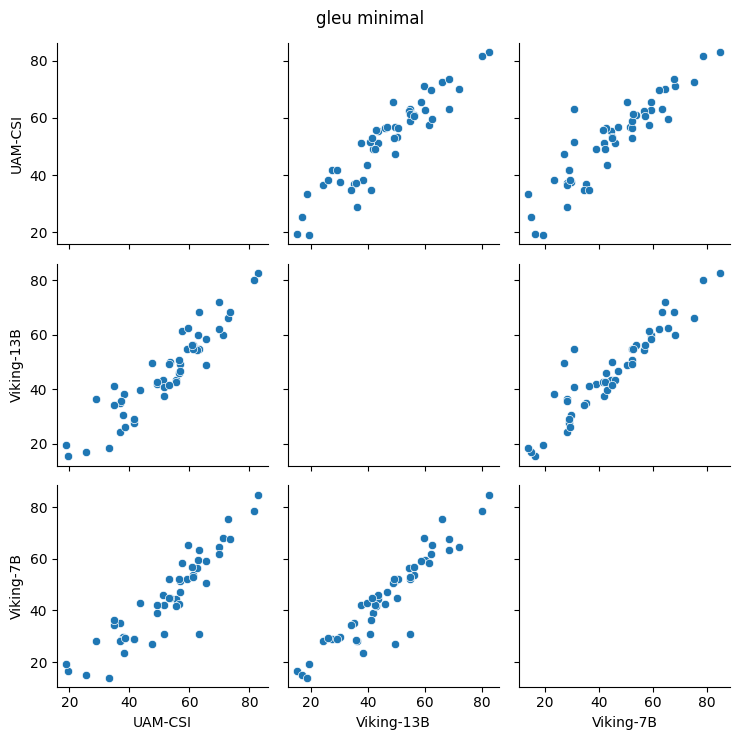

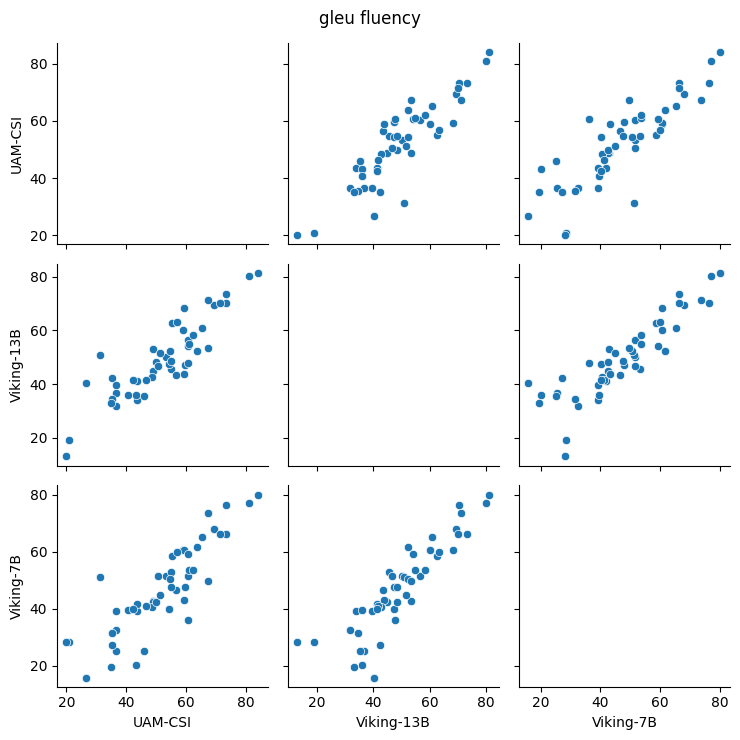

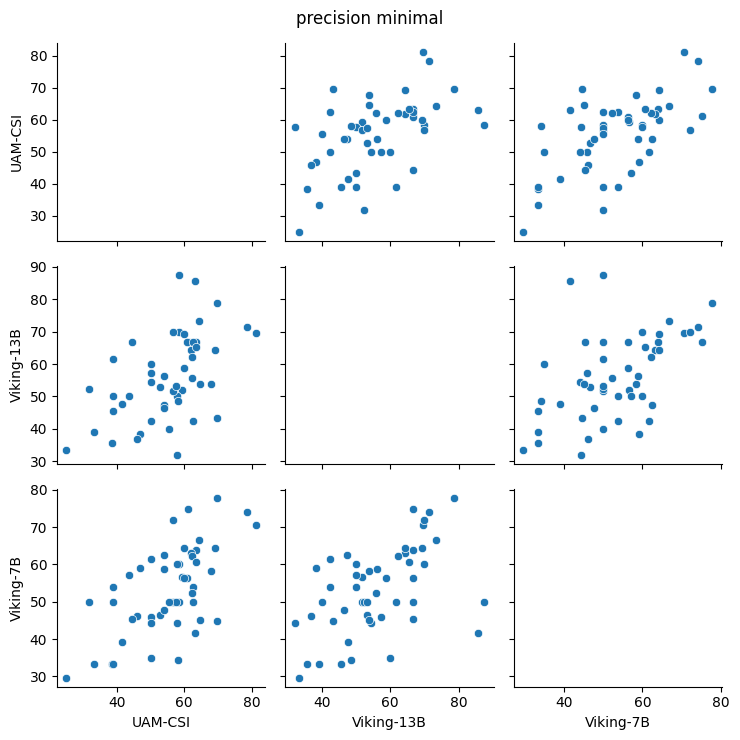

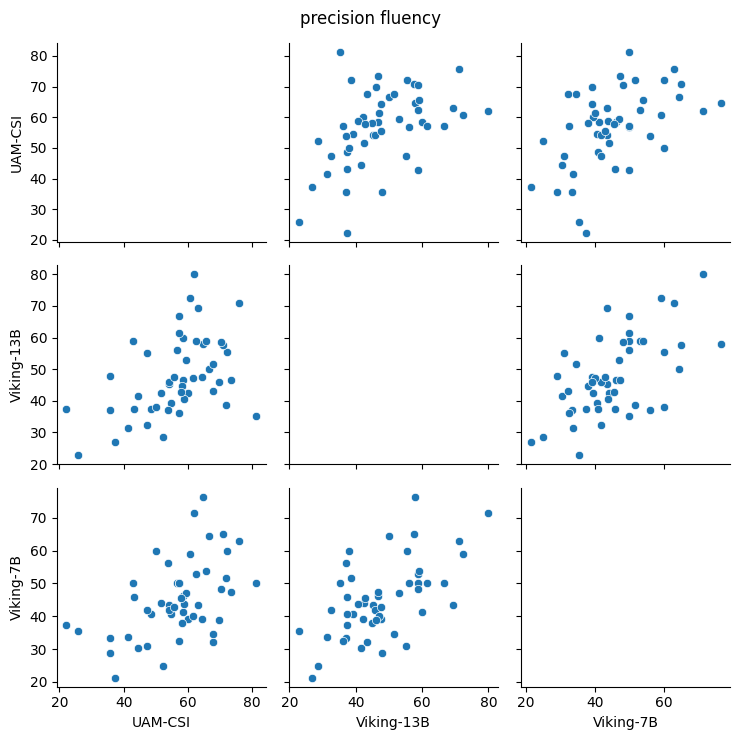

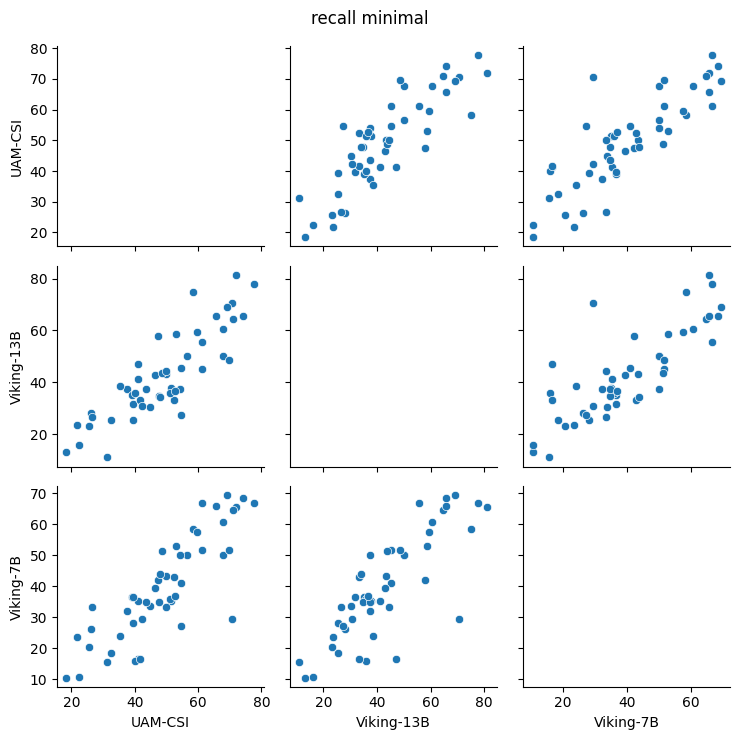

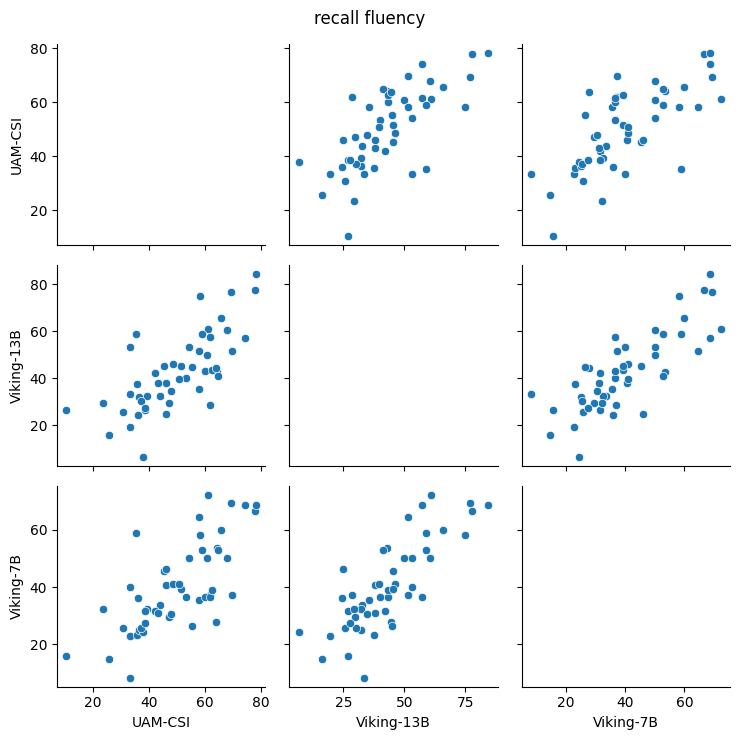

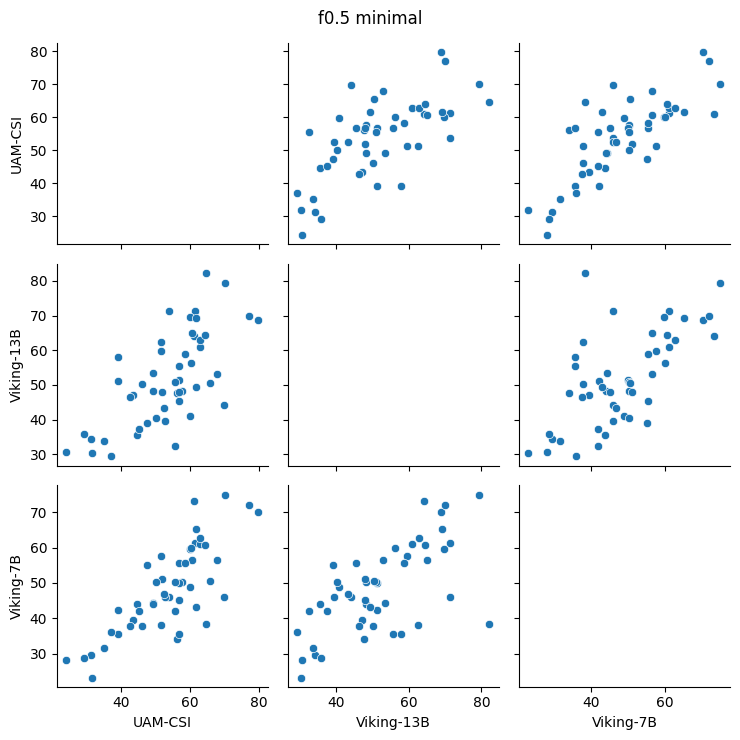

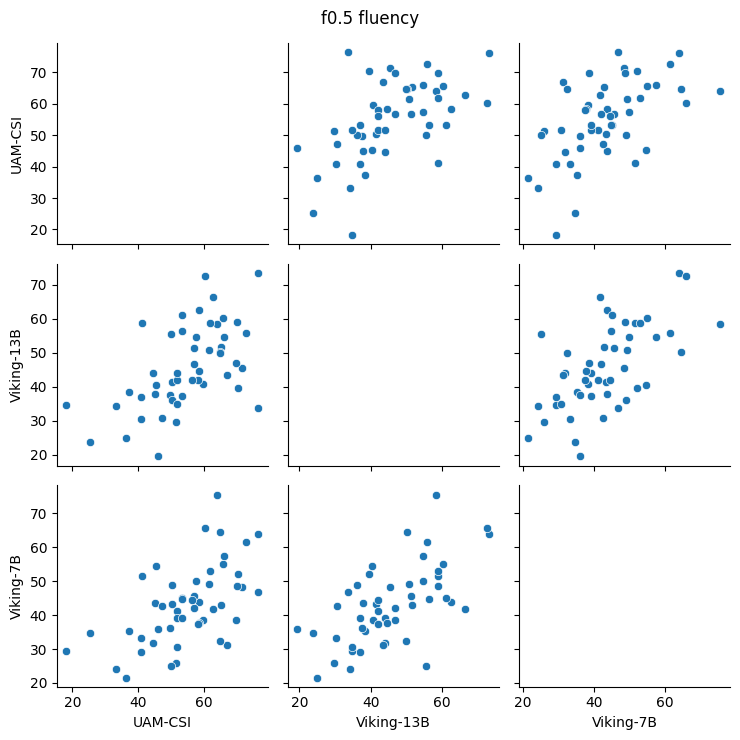

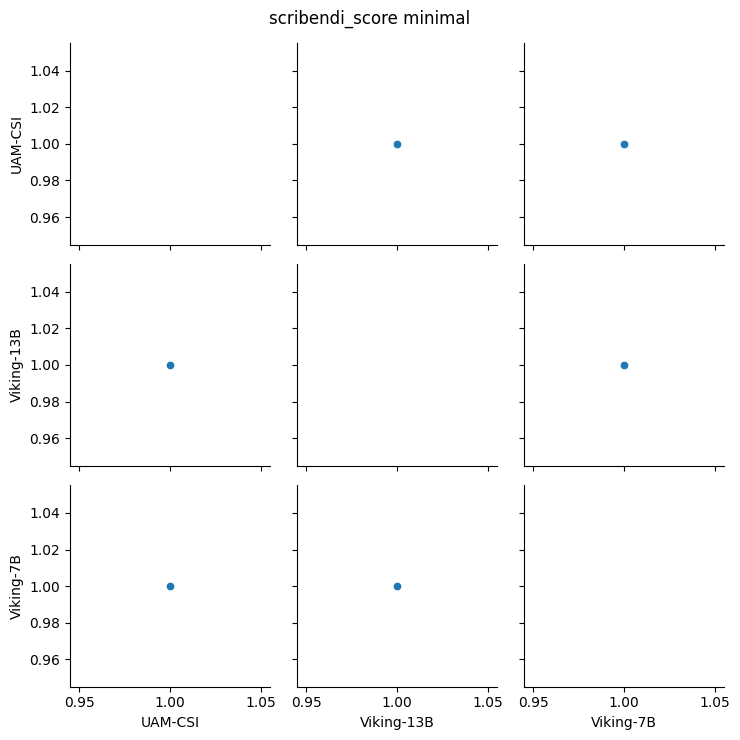

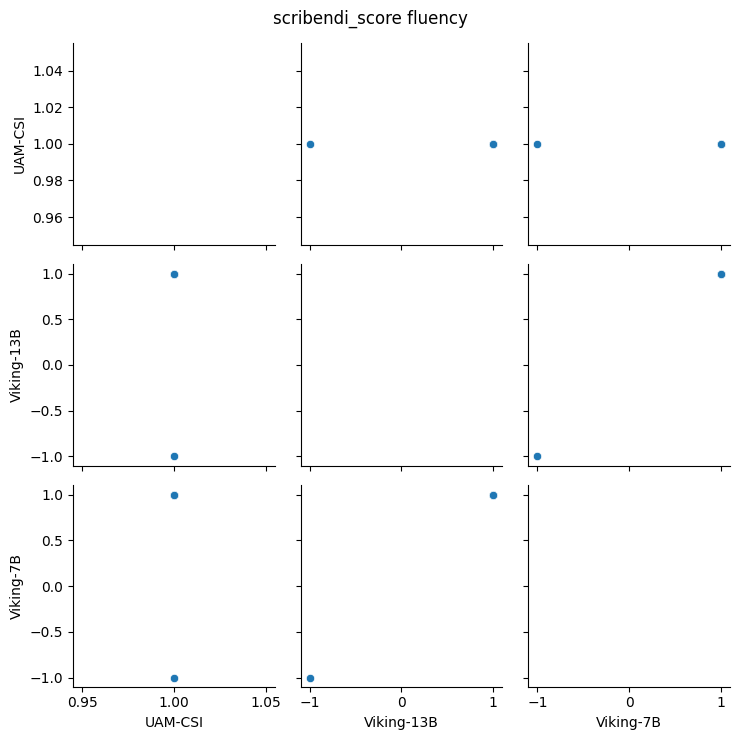

In [33]:
# pairwise_long = pairwise_df.melt(
#    id_vars=[styles_label, team_label, "essay_id"],
#    var_name="score_type",
#    value_name="score"
# )
# pairwise_long["essay_id"] = pairwise_long["essay_id"].astype(str)
# Filter to only the relevant score columns + correction_style
score_cols = ['gleu', 'precision', 'recall', 'f0.5', 'scribendi_score']
plot_df = pairwise_df[score_cols + ['correction_style']].copy()

styles = pairwise_df["correction_style"].unique()
teams = pairwise_df["system"].unique()
for score in score_cols:
    score_subset = pairwise_df[
        ["essay_id", "system", "correction_style", score]
    ]
    for style in styles:
        style_subset = score_subset[score_subset["correction_style"] == style]
        style_pivot = style_subset.pivot(
            index="essay_id",
            columns="system",
            values=score
        )
        sns.pairplot(
            style_pivot,
            diag_kind="None",
        )
        plt.suptitle(f"{score} {style}")
        plt.tight_layout()
        plt.show()
    # score_df = pairwise_df[["system", "correction_style", score]]
    # TODO: Finish

# sns.pairplot(pairwise_df)

# Create pairplot with seaborn
# sns.pairplot(
#    plot_df,
#    hue='correction_style',
#    palette='Set2',
#    diag_kind='kde',  # or 'hist'
#    plot_kws={'alpha': 0.7, 's': 40},  # transparency & point size
#    corner=True  # Optional: omit mirrored plots
# )
#
# plt.suptitle("Pairwise Score Comparisons by Correction Style",
#             fontsize=16, y=1.02)
# plt.tight_layout()
# plt.show()

In [65]:
baseline = "UAM-CSI"
comparison_systems = pairwise_df["system"].unique().tolist()
comparison_systems.remove(baseline)
diffs = pd.DataFrame()
for score in score_cols:
    score_subset = pairwise_df[
        ["essay_id", "system", "correction_style", score]
    ]
    for style in styles:
        style_subset = score_subset[
            score_subset["correction_style"] == style
        ]
        style_pivot = style_subset.pivot(
            index="essay_id",
            columns="system",
            values=score
        )
        for system in comparison_systems:
            label = ":".join(
                (system, score, style)
            )
            diffs[label] = (
                style_pivot[system] - style_pivot[baseline]
            )


summaries = []
for col in diffs.columns:
    system, score, style = col.split(":")
    gt = diffs[col][diffs[col] > 0].count()
    lt = diffs[col][diffs[col] < 0].count()
    eq = diffs[col][diffs[col] == 0].count()
    lo = diffs[col].min()
    hi = diffs[col].max()
    summaries.append(
        {
            "System": system,
            "Style": style,
            "Metric": score,
            "gt": gt,
            "lt": lt,
            "eq": eq,
            "max": hi,
            "min": lo,
        }
    )

diffs_summary = pd.DataFrame(summaries)
diffs_summary = diffs_summary.sort_values(
    by=["System", "Style", "Metric"]
)

print(diffs_summary)

        System    Style           Metric  gt  lt  eq    max    min
15  Viking-13B  fluency             f0.5  10  40   0  17.72 -42.76
3   Viking-13B  fluency             gleu  14  36   0  19.62 -15.40
7   Viking-13B  fluency        precision  11  39   0  18.10 -45.96
11  Viking-13B  fluency           recall   8  35   7  23.53 -33.33
19  Viking-13B  fluency  scribendi_score   0   1  49   0.00  -2.00
13  Viking-13B  minimal             f0.5  21  28   1  18.64 -25.50
1   Viking-13B  minimal             gleu   8  42   0   7.29 -16.51
5   Viking-13B  minimal        precision  27  22   1  29.17 -26.46
9   Viking-13B  minimal           recall   8  34   8  16.67 -27.28
17  Viking-13B  minimal  scribendi_score   0   0  50   0.00   0.00
14   Viking-7B  fluency             f0.5   6  44   0  11.63 -35.61
2    Viking-7B  fluency             gleu  11  39   0  19.84 -24.33
6    Viking-7B  fluency        precision   8  42   0  15.28 -35.39
10   Viking-7B  fluency           recall   6  39   5  23.53 -3